# Чат-бот со схемой коллекции

## Итоги предыдущего раздела

Мы расширили наш чат-бот для сохранения семантических воспоминаний в единый [профиль пользователя](https://docs.langchain.com/oss/python/concepts/memory#profile).

Мы также представили библиотеку [Trustcall](https://github.com/hinthornw/trustcall) для обновления этой схемы новой информацией.

## Цели текущего раздела

Иногда мы хотим сохранять воспоминания в [коллекцию](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200), а не в единый профиль.

Здесь мы обновим наш чат-бот для [сохранения воспоминаний в коллекцию](https://docs.langchain.com/oss/python/concepts/memory#collection).

Мы также покажем, как использовать Trustcall для обновления этой коллекции.


In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langchain_ollama langgraph trustcall langchain_core

In [2]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
os.environ["LANGSMITH_ENDPOINT"] = "https://eu.api.smith.langchain.com"

LANGSMITH_API_KEY:  ········


## Определение схемы коллекции

Вместо хранения информации о пользователе в фиксированной структуре профиля, мы создадим гибкую схему коллекции для хранения воспоминаний о взаимодействиях с пользователем.

Каждое воспоминание будет храниться как отдельная запись с единственным полем `content` для основной информации, которую мы хотим запомнить.

Этот подход позволяет нам создавать открытую коллекцию воспоминаний, которая может расти и меняться по мере того, как мы узнаем больше о пользователе.

Мы можем определить схему коллекции как объект [Pydantic](https://docs.pydantic.dev/latest/).

In [47]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [3]:
# _set_env("OPENAI_API_KEY")

Мы можем использовать метод [`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) интерфейса [чат-модели](https://docs.langchain.com/oss/python/langchain/models) LangChain для обеспечения структурированного вывода.

In [48]:
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama

# Initialize the model
model = ChatOllama(model="llama3.2:3b", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Lance. I like to bike.")])
memory_collection.memories

[Memory(content='Biking is a great way to explore new places and get some exercise.'),
 Memory(content='You can ride on trails, roads, or even through the city for a fun challenge.')]

Мы можем использовать `model_dump()` для сериализации экземпляра Pydantic-модели в словарь Python.

In [5]:
memory_collection.memories[0].model_dump()

{'content': 'Biking is a great way to explore new places and get some exercise.'}

Сохранить словарное представление каждого воспоминания в хранилище.

In [6]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

Найти воспоминания в хранилище.

In [7]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '0ba051f1-5cf4-46d1-9f0c-039989ce6ebf', 'value': {'content': 'Biking is a great way to explore new places and get some exercise.'}, 'created_at': '2025-11-07T08:51:56.050362+00:00', 'updated_at': '2025-11-07T08:51:56.050366+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '83edc4d1-e8a4-4c7f-b291-24105ca8b950', 'value': {'content': 'You can ride on trails, roads, or even through the city for a fun challenge.'}, 'created_at': '2025-11-07T08:51:56.050446+00:00', 'updated_at': '2025-11-07T08:51:56.050447+00:00', 'score': None}


## Обновление схемы коллекции

Мы обсудили проблемы с обновлением схемы профиля в прошлом уроке.

То же самое относится и к коллекциям!

Мы хотим иметь возможность обновлять коллекцию новыми воспоминаниями, а также обновлять существующие воспоминания в коллекции.

Теперь мы покажем, что [Trustcall](https://github.com/hinthornw/trustcall) также может использоваться для обновления коллекции.

Это позволяет как добавлять новые воспоминания, так и [обновлять существующие воспоминания в коллекции](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions
).

Давайте определим новый экстрактор с Trustcall.

Как и раньше, мы предоставляем схему для каждого воспоминания `Memory`.

Но мы можем указать `enable_inserts=True`, чтобы позволить экстрактору вставлять новые воспоминания в коллекцию.

In [23]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [24]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [25]:
# Result
from pprint import pprint
pprint(result)

{'attempts': 1,
 'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-11-07T09:05:41.23395234Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5463884699, 'load_duration': 146630554, 'prompt_eval_count': 202, 'prompt_eval_duration': 3904133833, 'eval_count': 27, 'eval_duration': 1370372002, 'model_name': 'llama3.2:3b', 'model_provider': 'ollama'}, id='lc_run--548b6857-5b91-4570-bde9-148d05b4ccf9-0', tool_calls=[{'name': 'Memory', 'args': {'content': 'I had a nice bike ride in San Francisco this morning.'}, 'id': 'e6665004-bff5-4b28-8410-eb964211c6d1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 202, 'output_tokens': 27, 'total_tokens': 229})],
 'response_metadata': [{'id': 'e6665004-bff5-4b28-8410-eb964211c6d1'}],
 'responses': [Memory(content='I had a nice bike ride in San Francisco this morning.')]}


In [26]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (e6665004-bff5-4b28-8410-eb964211c6d1)
 Call ID: e6665004-bff5-4b28-8410-eb964211c6d1
  Args:
    content: I had a nice bike ride in San Francisco this morning.


In [27]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='I had a nice bike ride in San Francisco this morning.'


In [28]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'e6665004-bff5-4b28-8410-eb964211c6d1'}


In [29]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'I had a nice bike ride in San Francisco this morning.'})]

In [30]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

Could not find existing schema in dict for <existing>


In [20]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================


In [22]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

Это говорит нам о том, что мы обновили первое воспоминание в коллекции, указав `json_doc_id`.

In [113]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_vxks0YH1hwUxkghv4f5zdkTr', 'json_doc_id': '0'}
{'id': 'call_Y4S3poQgFmDfPy2ExPaMRk8g'}


Трассировка LangSmith:

https://smith.langchain.com

## Чат-бот с обновлением схемы коллекции

Теперь давайте интегрируем Trustcall в наш чат-бот для создания и обновления коллекции воспоминаний.

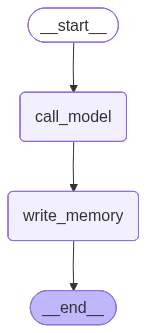

In [45]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOllama(model="llama3.2:3b", temperature=0)

# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [46]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Nice to meet you, Lance! I'm happy to chat with you and get to know you better. Since we're just starting our conversation, I don't have any prior knowledge about you yet. Would you like to tell me a bit more about yourself? What's been on your mind lately or what are some things you'd like to talk about?
[SystemMessage(content='Reflect on following interaction. \n\nUse the provided tools to retain any necessary memories about the user. \n\nUse parallel tool calling to handle updates and insertions simultaneously:', additional_kwargs={}, response_metadata={}), HumanMessage(content='Hi, my name is Lance', additional_kwargs={}, response_metadata={}, id='caf51d23-2ce4-4ac1-84ec-35a7402a8750'), AIMessage(content="Nice to meet you, Lance! I'm happy to chat with you and get to know you better. Since we're just

In [34]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

San Francisco is a great city for biking, with its scenic routes and mild climate. There's something special about exploring the city by two wheels, isn't there?

So, Lance, what do you enjoy most about biking in San Francisco? Is it the views of the Golden Gate Bridge, the hills and valleys of the city, or perhaps the vibrant neighborhoods like Haight-Ashbury or Fisherman's Wharf?

(By the way, I'm making a mental note to remember that you're a bike enthusiast from San Francisco. This will help me tailor our conversations to your interests!)


In [42]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

In [37]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Bakeries are a great addition to any city, and San Francisco has plenty of amazing ones to choose from! There's something special about indulging in freshly baked pastries, bread, or cakes.

Do you have a favorite type of bakery or pastry that you just can't get enough of? Are you more of a croissant fan, or do you have a sweet tooth for sourdough cookies?

(And, by the way, I'm starting to see a pattern here... it seems like we're discovering some common interests in San Francisco. Am I right?)


Продолжим разговор в новом потоке.

In [119]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you enjoy biking around San Francisco, you might like to check out some of these bakeries that are both delicious and located in areas that are great for a bike ride:

1. **Tartine Bakery** - Located in the Mission District, it's famous for its bread and pastries. The area is vibrant and perfect for a leisurely ride.

2. **Arsicault Bakery** - Known for its incredible croissants, it's in the Richmond District, which offers a nice ride through Golden Gate Park.

3. **B. Patisserie** - Situated in Lower Pacific Heights, this bakery is renowned for its kouign-amann and other French pastries. The neighborhood is charming and bike-friendly.

4. **Mr. Holmes Bakehouse** - Famous for its cruffins, it's located in the Tenderloin, which is a bit more urban but still accessible by bike.

5.

### LangSmith 

https://smith.langchain.com

## Studio

![Screenshot 2024-10-30 at 11.29.25 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0876d3daa19fef993ba_Screenshot%202024-11-11%20at%207.50.21%E2%80%AFPM.png)